## 1.分类问题 - 预测注册用户

In [1]:
# 网站来源，位置，是否读过FAQ，浏览网页数，选择服务类型
data=[['slashdot','USA','yes',18,'None'],
        ['google','France','yes',23,'Premium'],
        ['digg','USA','yes',24,'Basic'],
        ['kiwitobes','France','yes',23,'Basic'],
        ['google','UK','no',21,'Premium'],
        ['(direct)','New Zealand','no',12,'None'],
        ['(direct)','UK','no',21,'Basic'],
        ['google','USA','no',24,'Premium'],
        ['slashdot','France','yes',19,'None'],
        ['digg','USA','no',18,'None'],
        ['google','UK','no',18,'None'],
        ['kiwitobes','UK','no',19,'None'],
        ['digg','New Zealand','yes',12,'Basic'],
        ['slashdot','UK','no',21,'None'],
        ['google','UK','yes',18,'Basic'],
        ['kiwitobes','France','yes',19,'Basic']]

### 1.1 引入决策树

In [2]:
class DecisionNode:
  def __init__(self,col=-1,value=None,leaf=None,tb=None,fb=None):
    self.col=col
    self.value=value
    self.leaf=leaf
    self.tb=tb
    self.fb=fb

### 1.2 拆分方案

In [3]:
def divideSet(rows, column, value):
    split_function = None
    if isinstance(value, int) or isinstance(value, float):
        split_function = lambda row : row[column] >= value
    else:
        split_function = lambda row : row[column] == value
    
    set1 = [row for row in rows if split_function(row)]
    set2 = [row for row in rows if not split_function(row)]
    return [set1, set2]

In [4]:
divideSet(data, 2, 'yes')

[[['slashdot', 'USA', 'yes', 18, 'None'],
  ['google', 'France', 'yes', 23, 'Premium'],
  ['digg', 'USA', 'yes', 24, 'Basic'],
  ['kiwitobes', 'France', 'yes', 23, 'Basic'],
  ['slashdot', 'France', 'yes', 19, 'None'],
  ['digg', 'New Zealand', 'yes', 12, 'Basic'],
  ['google', 'UK', 'yes', 18, 'Basic'],
  ['kiwitobes', 'France', 'yes', 19, 'Basic']],
 [['google', 'UK', 'no', 21, 'Premium'],
  ['(direct)', 'New Zealand', 'no', 12, 'None'],
  ['(direct)', 'UK', 'no', 21, 'Basic'],
  ['google', 'USA', 'no', 24, 'Premium'],
  ['digg', 'USA', 'no', 18, 'None'],
  ['google', 'UK', 'no', 18, 'None'],
  ['kiwitobes', 'UK', 'no', 19, 'None'],
  ['slashdot', 'UK', 'no', 21, 'None']]]

In [5]:
# 统计label的种类分布，据此计算不纯度
def uniqueCounts(rows, column):
    values_count = {}
    for row in rows:
        value = row[column]    # label = row[len(row)-1]
        if value not in values_count:
            values_count[value] = 0
        values_count[value] += 1
    return values_count

In [6]:
# 基尼不纯度,是指将来自集合中的某种结果随机应用在集合中，某一数据项的预期误差率。
def giniImpurity(rows, column=-1):
    total = len(rows)
    values_count = uniqueCounts(rows,column)
    impurity = 0.0
    for value1 in values_count:
        p1 = float(values_count[value1]) / total
        p2 = 0.0
        for value2 in values_count:
            if value1 == value2:
                continue
            p2 += values_count[value2] / total
        impurity += (p1 * p2)
    return impurity

In [7]:
def entropy(rows,column=-1):
    from math import log
    log2 = lambda x:log(x)/log(2)
    values_count = uniqueCounts(rows,column)
    ent = 0.0
    for value in values_count.keys():
        p = float(values_count[value]) / len(rows)
        ent -= p * log2(p)
    return ent

In [8]:
giniImpurity(data,-1)

0.6328125

In [9]:
entropy(data,-1)

1.5052408149441479

In [10]:
set1, set2 = divideSet(data, 2, 'yes')

In [11]:
entropy(set1,-1)

1.2987949406953985

In [12]:
giniImpurity(set1,-1)

0.53125

### 1.3 以递归方式构造树

In [13]:
def buildTree(rows, impurity=entropy, gainRatio=False):
    if len(rows) == 0:
        return DecisionNode()
    currentImpurity = impurity(rows)
    bestGain = 0.0
    bestCriteria = None
    bestSets = None
    columnCount = len(rows[0]) - 1
    for col in range(0, columnCount):
        columnEntropy = 1.0
        if gainRatio:
            columnEntropy = impurity(rows, col)
            print(str(col) + ' 属性熵:' +str(columnEntropy))
        colValues = set()
        for row in rows:
            colValues.add(row[col])
        for value in colValues:
            (set1, set2) = divideSet(rows, col, value)
            p = float(len(set1)) / len(rows)
            nextImpurity = (p * impurity(set1)) + ((1 - p) * impurity(set2))
            gain = currentImpurity - nextImpurity
            if gainRatio:
                gain = gain / columnEntropy                
            if gain > bestGain and len(set1) > 0 and len(set2) > 0:
                bestGain = gain
                bestCriteria = (col, value)
                bestSets = (set1, set2)
    if bestGain > 0:
        trueBranch = buildTree(rows=bestSets[0], impurity=impurity)
        falseBranch = buildTree(rows=bestSets[1], impurity=impurity)
        return DecisionNode(col=bestCriteria[0], value=bestCriteria[1], tb=trueBranch, fb=falseBranch)
    else:
        return DecisionNode(leaf=uniqueCounts(rows,column=-1)) 

### 1.4 显示树

In [14]:
def printTree(node, indent=' '):
    if node.leaf != None:
        print(str(node.leaf))
    else:
        print(indent + str(node.col) + ' : ' + str(node.value) + ' ?')
        print(indent + 'T ->', printTree(node.tb, indent + ' '))
        print(indent + 'F ->', printTree(node.fb, indent + ' '))

In [15]:
printTree(buildTree(data,gainRatio=True))

0 属性熵:2.257856063692049
1 属性熵:1.9056390622295662
2 属性熵:1.0
3 属性熵:2.5306390622295662
 2 : yes ?
  0 : slashdot ?
{'None': 2}
  T -> None
   0 : google ?
    1 : UK ?
{'Basic': 1}
    T -> None
{'Premium': 1}
    F -> None
   T -> None
{'Basic': 4}
   F -> None
  F -> None
 T -> None
  3 : 21 ?
   0 : google ?
{'Premium': 2}
   T -> None
    0 : slashdot ?
{'None': 1}
    T -> None
{'Basic': 1}
    F -> None
   F -> None
  T -> None
{'None': 4}
  F -> None
 F -> None


In [16]:
# 一个分支的总宽度等于所有子宽度之和，没有子分支的话，宽度为1
def getWidth(tree):
    if tree.tb == None and tree.fb == None:
        return 1
    return getWidth(tree.tb) + getWidth(tree.fb)
def getHeight(tree):
    if tree.tb == None and tree.tb == None:
        return 0
    return max(getHeight(tree.tb), getHeight(tree.fb)) + 1

In [41]:
from PIL import Image, ImageDraw

def drawNode(draw, node, x, y):
    if node.leaf == None:
        w1 = getWidth(node.fb) * 100
        w2 = getWidth(node.tb) * 100
        left = x - (w1+w2)/2
        right = x + (w1+w2)/2
        draw.text((x-20,y-20), str(node.col)+':'+str(node.value), (0,0,0))
        draw.line((x,y, left+w1/2,y+75), fill=(255,0,0))
        draw.line((x,y, right-w2/2,y+75), fill=(0,255,0))
        drawNode(draw, node.fb, left+w1/2, y+100)
        drawNode(draw, node.tb, right-w2/2, y+100)
    else:
        for item in node.leaf.items():
            print('%s:%d'%item)
        txt=' \n'.join(['%s:%d'%v for v in node.leaf.items()])
        draw.text((x-20,y-20),txt,(0,0,0))
def drawTree(tree, jpeg='tree.jpg'):
    w = getWidth(tree) * 100
    h = getHeight(tree) * 100 + 120
    image = Image.new('RGB',(w,h),(255,255,255))
    draw = ImageDraw.Draw(image)
    drawNode(draw, tree, w/2, 20)
    image.save(jpeg, 'JPEG')

In [42]:
drawTree(buildTree(data,gainRatio=False), jpeg='treeview.jpg')

None:3
Basic:1
Basic:4
None:3
None:1
Basic:1
Premium:3


### 1.5 对新的观察数据进行分类

In [43]:
def classify(observation, tree):
    if tree.leaf != None:
        return tree.leaf
    else:
        value = observation[tree.col]
        branch = None
        if isinstance(value, int) or isinstance(value, float):
            if value >= tree.value:
                branch = tree.tb
            else:
                branch = tree.fb
        else:
            if value == tree.value:
                branch = tree.tb
            else:
                branch = tree.fb
        return classify(observation, branch)

In [65]:
tree = buildTree(data)

In [66]:
classify(['(direct)','USA','yes',5], tree)

{'Basic': 4}

### 1.6 剪枝 Pruning the Tree

In [67]:
def prune(tree, minGain):
    if tree.tb.leaf == None:
        prune(tree.tb, minGain)
    if tree.fb.leaf == None:
        prune(tree.fb, minGain)
    if tree.tb.leaf != None and tree.fb.leaf != None:
        tb, fb = [], []
        for v,c in tree.tb.leaf.items():
            tb += [[v]] * c
            print('[[v]] * c : ',[[v]] * c)
            print('tb += [[v]] * c : ', tb)
        for v,c in tree.fb.leaf.items():
            fb += [[v]] * c
        
        tp = float(len(tb)) / (len(tb) + len(fb)) 
        gain = entropy(tb+fb) - (tp*entropy(tb) + (1-tp)*entropy(fb))
        if gain < minGain:
            tree.tb, tree.fb = None, None
            tree.leaf = uniqueCounts(tb+fb, -1)

In [68]:
tree2 = buildTree(data)
prune(tree2, 1)

[[v]] * c :  [['Basic']]
tb += [[v]] * c :  [['Basic']]
[[v]] * c :  [['Basic']]
tb += [[v]] * c :  [['Basic']]
[[v]] * c :  [['Basic'], ['Basic'], ['Basic'], ['Basic']]
tb += [[v]] * c :  [['Basic'], ['Basic'], ['Basic'], ['Basic']]
[[v]] * c :  [['None'], ['None'], ['None']]
tb += [[v]] * c :  [['None'], ['None'], ['None']]


In [69]:
drawTree(tree2, jpeg='treeviewPrune.jpg')

None:6
Basic:5
None:1
Basic:1
Premium:3


### 1.7 处理缺失数据(Dealing with missing data)

In [70]:
def missDataClassify(observation, tree):
    if tree.leaf != None:
        return tree.leaf
    else:
        value = observation[tree.col]
        if value != None:
            branch = None
            if isinstance(value, int) or isinstance(value, float):
                if value >= tree.value:
                    branch = tree.tb
                else:
                    branch = tree.fb
            else:
                if value == tree.value:
                    branch = tree.tb
                else:
                    branch = tree.fb
            return missDataClassify(observation, branch)
        else:
            tb_leafs, fb_leafs = missDataClassify(observation, tree.tb), missDataClassify(observation, tree.fb)
            tb_count = sum(tb_leafs.values())
            fb_count = sum(fb_leafs.values())
            total_count = tb_count + fb_count
            tb_weight = tb_count / total_count
            fb_weight = fb_count / total_count
            leafs = {}
            for v,c in tb_leafs.items():
                leafs[v] = tb_weight * c
            for v,c in fb_leafs.items():
                if v not in leafs:
                    leafs[v] = 0
                leafs[v] += fb_weight * c
            return leafs

In [72]:
tree = buildTree(data)
missDataClassify(['google', None, 'yes', None], tree2)

{'Premium': 2.25, 'Basic': 0.25}

In [73]:
missDataClassify(['google', 'France', None, None], tree)

{'Premium': 2.25, 'Basic': 0.125, 'None': 0.125}

## 2. 回归问题 - 对住房价格进行建模
- 使用方差作为评价函数代替熵或基尼不纯度
- 拆分条件：拆分之后另数字较大的位于树的一侧，数字较小的位于树的另一侧，便可可以降低分支的整体方差

In [74]:
def variance(rows, column=-1):
    if len(rows)==0:
        return 0
    yData = [float(row[column]) for row in rows]
    mean = sum(yData) / len(yData) 
    var = sum([(d - mean)**2 for d in yData]) / len(yData)
    return var

### 可以尝试爬取链家网，对住房价格进行建模
### 或者可以对股票价格进行建模

## 2. 模拟sklean构建一个决策树模型

In [1]:
from collections import Counter
from math import log
import numpy as np

class TreeModelClassifier:
    def __init__(self, criterion='entropy', max_depth=20):
        def entropy(y):
            counter = Counter(y)
            res = 0.0
            for num in counter.values():
                p = num / len(y)
                res += -p * log(p)
            return res
        self.criterion = eval(criterion)
        self.rootNode = None
        self.maxDepth = max_depth
        self.countDepth = -1

    def fit(self, X, y):
        assert len(X) > 0 and len(X) == len(y), 'The X or y must be valid.'
        X = np.array(X)
        y = np.array(y)
        self.rootNode = self._constructTree(X, y)
        return self

    def predict(self, X):
        assert self.rootNode is not None, 'must fit before predict.'
        assert len(X) > 0, 'len(X) should > 0.'
        y_predict = [self._predict(x) for x in X]
        return np.array(y_predict)

    class Node:
        def __init__(self, col=-1, value=None, leaf=None, trueBranch=None, falseBranch=None):
            self.col = col
            self.value = value
            self.leaf = leaf
            self.trueBranch = trueBranch
            self.falseBranch = falseBranch

    def _divideData(self, X_column, value):
        splitFn = None
        if isinstance(value, int) or isinstance(value, float):
            splitFn = lambda x : x >= value
        else:
            splitFn = lambda x : x == value
        trueIndex = [i for i in range(0, len(X_column)) if splitFn(X_column[i])]
        falseIndex = [i for i in range(0, len(X_column)) if not splitFn(X_column[i])]
        return (trueIndex, falseIndex)

    def _constructTree(self, X_, y_):
        assert len(X_) == len(y_), 'len(X), len(y) must be equal.'
        if len(X_) == 0: return TreeModelClassifier.Node()
        self.countDepth += 1
        currentImpurity = self.criterion(y_)
        bestGain, bestSplits, bestIndexes = 0, None, None
        for col in range(0, len(X_[0])):
            colCounter = Counter(X_[:,col])
            for value in colCounter:
                (trueIndex, falseIndex) = self._divideData(X_[:,col], value)
                trueProb = float(len(trueIndex)) / len(X_)
                nextImpurity = trueProb * self.criterion(y_[trueIndex]) \
                               + (1-trueProb) * self.criterion(y_[falseIndex])
                gain = currentImpurity - nextImpurity
                if gain > bestGain and len(trueIndex) > 0 and len(falseIndex) > 0:
                    bestGain, bestSplits, bestIndexes = gain, (col, value), (trueIndex, falseIndex)
        if bestGain > 0 and len(bestIndexes[0]) > 0 and len(bestIndexes[1]) > 0 and self.countDepth < self.maxDepth:
            trueBranch = self._constructTree(X_[bestIndexes[0]].copy(), y_[bestIndexes[0]].copy())
            falseBranch = self._constructTree(X_[bestIndexes[1]].copy(), y_[bestIndexes[1]].copy())
            return TreeModelClassifier.Node(col=bestSplits[0], value=bestSplits[1], trueBranch=trueBranch, falseBranch=falseBranch)
        else:
            return TreeModelClassifier.Node(leaf=Counter(y_))

    def _predict(self, x):
        tree = self.rootNode
        leafCounter = self._classify(x, tree)
        return leafCounter.most_common(1)[0][0]

    def _classify(self, x, tree):
        if tree.leaf != None: return tree.leaf
        else:
            value = x[tree.col]
            branch = None
            if isinstance(value, int) or isinstance(value, float):
                if value >= tree.value: branch = tree.trueBranch
                else: branch = tree.falseBranch
            else:
                if value == tree.value: branch == tree.trueBranch
                else: branch = tree.falseBranch
            return self._classify(x, branch)

In [2]:
def plot_decision_boundary(model, axis):
    x0, x1 = np.meshgrid(
        np.linspace(axis[0], axis[1], int((axis[1]-axis[0])*100)).reshape(-1, 1),
        np.linspace(axis[2], axis[3], int((axis[3]-axis[2])*100)).reshape(-1, 1),
    )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_predict = model.predict(X_new)
    zz = y_predict.reshape(x0.shape)
    from matplotlib.colors import ListedColormap
    custom_cmap = ListedColormap(['#EF9A9A','#FFF59D','#90CAF9'])
    plt.contourf(x0, x1, zz, cmap=custom_cmap)

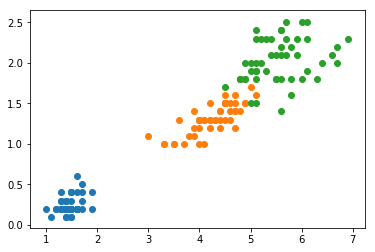

In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:,2:]
y = iris.target
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

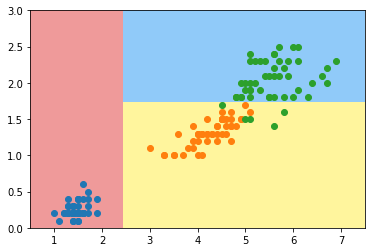

In [5]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(max_depth=2, criterion="entropy")
dt_clf.fit(X, y)
plot_decision_boundary(dt_clf, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

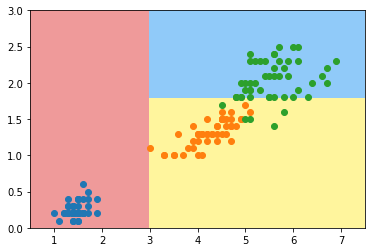

In [6]:
clt = TreeModelClassifier(max_depth=2)
clt.fit(X, y)
plot_decision_boundary(clt, axis=[0.5, 7.5, 0, 3])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.scatter(X[y==2,0], X[y==2,1])
plt.show()

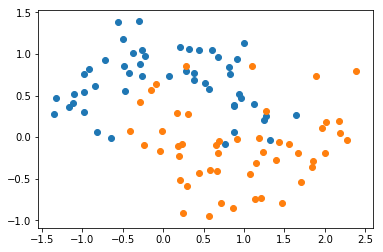

In [7]:
from sklearn import datasets
X, y = datasets.make_moons(noise=0.25, random_state=666)
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

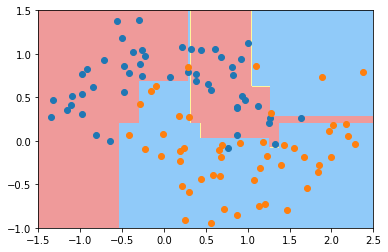

In [17]:
from sklearn.tree import DecisionTreeClassifier
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X, y)
plot_decision_boundary(dt_clf, axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()

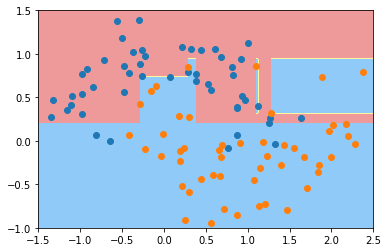

In [16]:
clt1 = TreeModelClassifier()
clt1.fit(X, y)
plotDecisionBoundary(clt1, axis=[-1.5,2.5,-1.0,1.5])
plt.scatter(X[y==0,0], X[y==0,1])
plt.scatter(X[y==1,0], X[y==1,1])
plt.show()